In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
prefix = '/data/kylevigil/'

# Machine Learning

In this notebook I will be creating a model to predict movie genre based off of movie metadata.

First I import the table created from the data cleaning process.

In [3]:
moviesData = pd.read_pickle(prefix + 'moviesData.pkl')
moviesData.head()

,title,year,rtAudienceNumRatings,rtAudienceScore,titleSentiment,realGenre,genreNum,directorName,directorNum,posterColor,color,colorNum,actorName,actorNum,tagSentiment,countryNum
1,Toy story,1995,102338,81,0.0,Comedy,1,John Lasseter,2027,dark red,"(104.392166836, 54.7272562127, 43.522889115)",5,Tom Hanks,7241,0.356944,66
3,Grumpy Old Men,1993,10489,66,0.1,Romance,5,Donald Petrie,1038,white,"(240.257754103, 245.865108686, 244.831228342)",11,Jack Lemmon,3122,0.100000,66
5,Father of the Bride Part II,1995,13761,64,0.0,Comedy,1,Charles Shyer,609,dark red,"(66.3822844645, 58.6215606039, 44.2912374771)",5,Steve Martin,6881,0.000000,66
6,Heat,1995,42785,92,0.0,Action,0,Michael Mann,2716,light blue,"(148.308032972, 178.875707128, 227.418005495)",6,Al Pacino,120,0.060606,66
7,Sabrina,1954,12812,87,0.0,Romance,5,Billy Wilder,398,black,"(11.6874206517, 10.4756312597, 11.2805579066)",0,Humphrey Bogart,3009,0.000000,66


Then I create tables of the parameters and the target

In [4]:
X = moviesData[['year','rtAudienceNumRatings','rtAudienceScore','directorNum','titleSentiment',
                'colorNum','actorNum','tagSentiment','countryNum']]
y = moviesData['genreNum']

In [5]:
X.dtypes

year                      int64
rtAudienceNumRatings      int64
rtAudienceScore           int64
directorNum               int16
titleSentiment          float64
colorNum                   int8
actorNum                  int16
tagSentiment            float64
countryNum                 int8
dtype: object

The first classifier I use to make the model is the Random Forest

In [6]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [7]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(Xtrain, ytrain)
guess = model.predict(Xtest)

This model gives a accuracy of aroung 50% which isn't as good as I hoped but it it still more than twice as good as random guessing.

In [8]:
model.score(Xtest, ytest)

0.52136317395727361

To find the average percent accuracy I will take a couple of samples and average the score

In [9]:
def return_score():
    """ returns the score of one trial """
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)
    m = RandomForestClassifier()
    m.fit(Xtrain, ytrain)
    m.predict(Xtest)
    return m.score(Xtest, ytest)

In [10]:
def return_average(n):
    """ returns average score"""
    return np.array([return_score() for i in range(n)]).mean()

In [11]:
return_average(10)

0.50910478128179049

The confusion matrix shows that there is no clear cluster of confusion genres, it is just only accurate half the time in general. One thing to note is the difficulty in guessing the difference between romance and drama and that would make sense due to the overlap between the two.

In [12]:
from sklearn.metrics import confusion_matrix

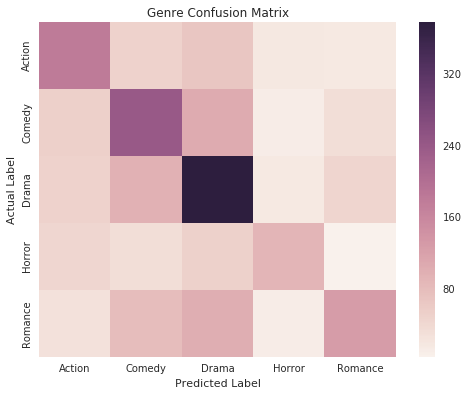

In [13]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(ytest, guess), xticklabels=pd.Categorical(moviesData['realGenre']).categories,
                                            yticklabels=pd.Categorical(moviesData['realGenre']).categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Genre Confusion Matrix')
plt.show()

Now to look at what features are the most important. It seems that the color, country, and title sentiment don't matter as much as the others.

In [14]:
pd.DataFrame(model.feature_importances_, X.columns.values, columns=['importance']).sort_values('importance', ascending = False)

,importance
directorNum,0.179685
year,0.166843
actorNum,0.128792
rtAudienceNumRatings,0.123753
tagSentiment,0.121009
rtAudienceScore,0.109454
colorNum,0.068978
countryNum,0.059841
titleSentiment,0.041646


So for attempt number two I will reduce the number of features to try to correct for over fitting. I will drop the countryNum and titleSentiment features.

In [15]:
X = moviesData[['year','rtAudienceNumRatings','rtAudienceScore','directorNum','colorNum','actorNum','tagSentiment']]
y = moviesData['genreNum']

In [16]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
model2 = RandomForestClassifier()
model2.fit(Xtrain, ytrain)
guess2 = model2.predict(Xtest)

As you can see this model did slightly worse than the last one meaning the features that were dropped were indeed important.

In [17]:
model2.score(Xtest, ytest)

0.50050864699898268

Average Score:

In [18]:
return_average(10)

0.50264496439471018

The confusion matrix and features importance look basically the same as the first model

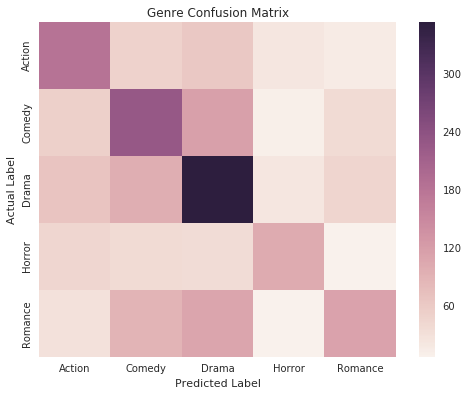

In [19]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(ytest, guess2), xticklabels=pd.Categorical(moviesData['realGenre']).categories,
                                            yticklabels=pd.Categorical(moviesData['realGenre']).categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Genre Confusion Matrix')
plt.show()

In [20]:
pd.DataFrame(model2.feature_importances_, X.columns.values, columns=['importance']).sort_values('importance', ascending = False)

,importance
directorNum,0.207622
year,0.178487
actorNum,0.151447
rtAudienceNumRatings,0.133504
tagSentiment,0.129494
rtAudienceScore,0.119265
colorNum,0.080181


For fun I decided to also try a different type of model, the naive bayes classifier. This model did significantly worse than the Random Forest. It was only a tiny bit better than a random guess. It also seems like it predicted drama which is the most heavily represented category most of the time.

In [21]:
from sklearn.naive_bayes import GaussianNB
NBmodel = GaussianNB()
NBmodel.fit(Xtrain, ytrain)
guess3 = NBmodel.predict(Xtest)

In [22]:
NBmodel.score(Xtest, ytest)

0.31892166836215669

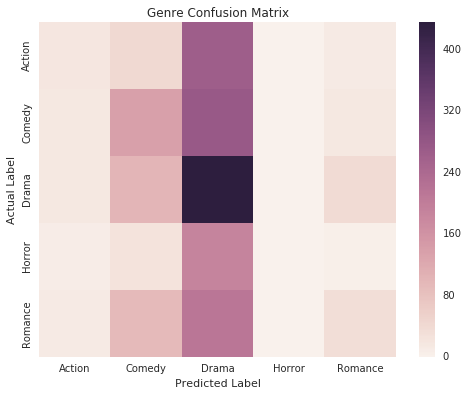

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(ytest, guess3), xticklabels=pd.Categorical(moviesData['realGenre']).categories,
                                            yticklabels=pd.Categorical(moviesData['realGenre']).categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Genre Confusion Matrix')
plt.show()

## Bonus Model

I was personally unsatisfied by the low prediction rate of 50% so in an effort to predict something with more accuracy I decided to look at less genres

In [24]:
lessGenres = moviesData[[i == 'Horror' or i == 'Romance' for i in moviesData.realGenre]]
lessGenres[['title','realGenre']].head()

,title,realGenre
3,Grumpy Old Men,Romance
7,Sabrina,Romance
11,The American President,Romance
12,Dracula: Dead and Loving It,Horror
17,Sense and Sensibility,Romance


In [25]:
X = lessGenres[['year','rtAudienceNumRatings','rtAudienceScore','directorNum','colorNum','actorNum','tagSentiment']]
y = lessGenres['genreNum']

In [26]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
bonusModel = RandomForestClassifier()
bonusModel.fit(Xtrain, ytrain)
bonusGuess = bonusModel.predict(Xtest)

As you can see, this model predicted the difference between a horror movie and a romance movie which are two of the most polarized movie genres with pretty decent accuracy. 

In [27]:
bonusModel.score(Xtest, ytest)

0.82522522522522523

Average Score:

In [28]:
return_average(100)

0.81425225225225228

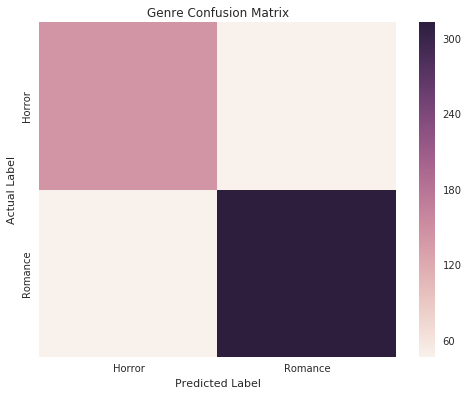

In [29]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(ytest, bonusGuess), xticklabels=pd.Categorical(lessGenres['realGenre']).categories,
                                            yticklabels=pd.Categorical(lessGenres['realGenre']).categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Genre Confusion Matrix')
plt.show()

Satisfyingly enough, the color of the movie poster turned out to be quite important on the features list which validates the effort I put into gathering that data.

In [30]:
pd.DataFrame(bonusModel.feature_importances_, X.columns.values, columns=['importance']).sort_values('importance', ascending = False)

,importance
directorNum,0.177573
year,0.166937
tagSentiment,0.164717
colorNum,0.144940
rtAudienceScore,0.120817
rtAudienceNumRatings,0.120727
actorNum,0.104289


This next section shows how this model is especially hard to make accurate. I reduce the number of dimensions to two and as you can see there is no clear grouping when using the top four features based on importance

In [31]:
from sklearn.decomposition import PCA

pca = PCA(2)
projected = pca.fit_transform(moviesData[['year','tagSentiment','actorNum','directorNum']])

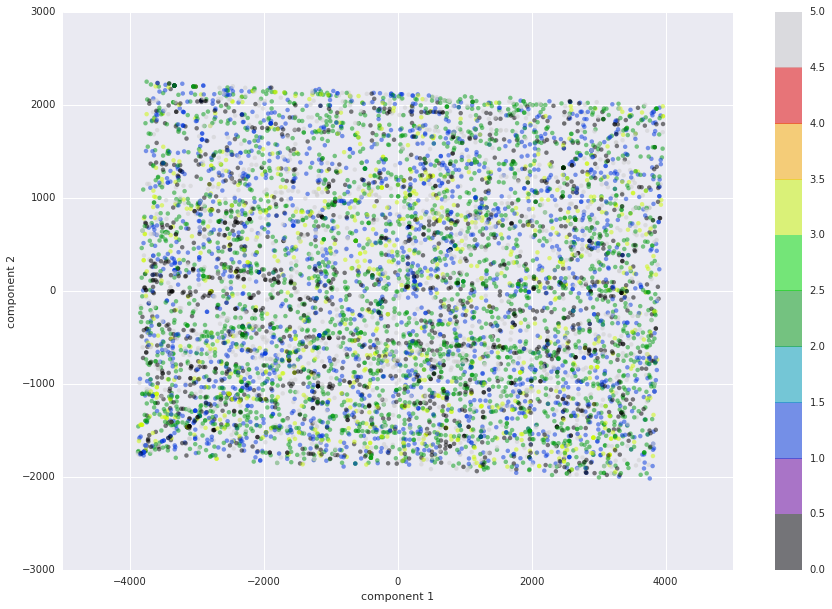

In [32]:
plt.figure(figsize = (15,10))

plt.scatter(projected[:, 0], projected[:, 1],
            c=moviesData['genreNum'], edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();